In [2]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns
import numpy as np
import pandas as pd

import os
import joblib
import pickle
import dill
from datetime import datetime, date
import cmocean
import fitz
from load_processed import load_processed, Strat
from neuralUtils import *
from analysisUtils import *
from analysis_by_class import *

import sys
sys.path.append('../utils')
from db import get_db_info, create_connection, execute_sql, select_db, NumpyEncoder
from plotting import *
from protocols import load_params
from matio import loadmat

sys.path.append('../behavior_analysis')
from traceUtils import check_stats, setUpLickingTrace

import sqlite3
import warnings
import hashlib
import json
import psutil
import itertools

In [2]:
plt.style.use('paper_export')

In [3]:
# need to change only this line
plot_fig = 'fig1'  # 'fig1' or 'EDfig10'

In [4]:
protocol = 'SameRewDist'

In [10]:
if plot_fig == 'fig1':
    table = 'ephys'
    activity_type = 'firing'  # this is smoothed at the level of the raw timecourse, not the averages
    manipulation = 'combined'
    class_name = 'helper'
    class_labels = ['all']
elif plot_fig == 'EDfig10':
    table = 'imaging'
    activity_type = 'spks_smooth'
    manipulation = 'virus'
    class_name = 'genotype'
    class_labels = ['D1-Cre', 'A2a-Cre']
else:
    raise Exception('fig not supported')

In [11]:
paths = get_db_info()
colors, protocol_info, periods, kwargs = load_params(protocol)
kwargs['manipulation'] = manipulation 

# create SQL query based on keyword arguments passed to function
_, sql = construct_where_str(protocol, kwargs, table)
rets = execute_sql(sql, paths['db'])

# handle stats kwarg case, which requires reading in the entire JSONified string of the table
alpha = periods['alpha']
rets = check_stats(rets, kwargs['stats'], protocol_info['pairs_to_check'], alpha)

# plot order
po = np.argsort(protocol_info['mean'][:protocol_info['n_trace_types']])
pou = np.insert(po, protocol_info['n_trace_types'], protocol_info['n_trace_types'])  # including unexpected reward

In [12]:
ret_df = pd.DataFrame(rets, columns=rets[0].keys())

In [16]:
spec = str(manipulation) + '_'

if table == 'ephys':
    spec += kwargs['probe1_region']
elif 'genotype' in kwargs:
    spec += kwargs['genotype'].split()[0]
elif table == 'imaging':
    spec += 'combined'
    
# hash rets consistently from machine to machine
dhash = hashlib.md5()
encoded = json.dumps(kwargs, sort_keys=True, cls=NumpyEncoder).encode()
dhash.update(encoded)
hashed = dhash.hexdigest()

# save variables
save_path = os.path.join(paths['neural_fig_roots'][1], '_'.join([protocol, table, spec, activity_type + '.sav']))

In [17]:
if os.path.exists(save_path):
    print('Found saved vars at {}.'.format(save_path))
    with open(save_path, 'rb') as f:
        d = joblib.load(f)    
else:
    raise Exception(f'Could not find data in {save_path}. Ensure that data has been copied into the relevant folder, or change `save_path`.')

Found saved vars at ../../data/neural-plots/SameRewDist_imaging_virus_combined_spks_smooth.sav.


In [18]:
# bring loaded variables into namespace
for var in d.keys():
    exec("{} = d['{}']".format(var, var))

del d
# assert n_rets == len(rets)

In [20]:
ds_factor

0

In [23]:
trace_dict = {'cs_in': 0,
              'cs_out': 1,
              'trace_end': 3,
              'xlim': (-1, 5),
              'ylabel': '',
              'xlabel': 'Time from CS (s)'
              }

In [24]:
if table == 'ephys':
    
    neuron_info, reg_labels = assign_str_regions_from_kim(neuron_info)
    neuron_info['helper'] = 'all'
    ds_factor = int((len(pcolor_time_full) - 1) / 500)
   
else:
    neuron_info = pd.DataFrame(neuron_info)
    ds_factor = 1

total_cells = len(neuron_info)
pcolor_time = pcolor_time_full[::ds_factor]
std_time = (pcolor_time[:-1] + pcolor_time[1:]) / 2  # midpoints of pcolor_time, since pcolor labels both endpoints

## ED Fig. 2b, 10a-b 

/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysisUtils.py:178: RuntimeWarning: Mean of empty slice
  grand_mean = np.nanmean(timecourse, axis=1)
/n/holystore01/LABS/uchida_users/Users/alowet/dist-rl/to_publish/code/neural_analysis/analysisUtils.py:178: RuntimeWarning: Mean of empty slice
  grand_mean = np.nanmean(timecourse, axis=1)


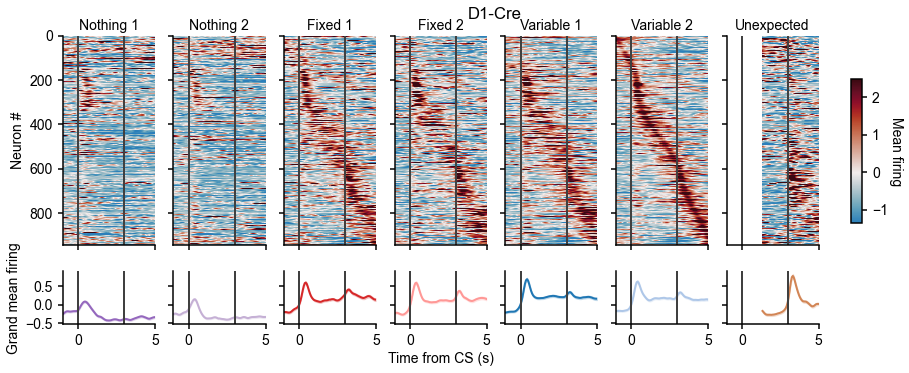

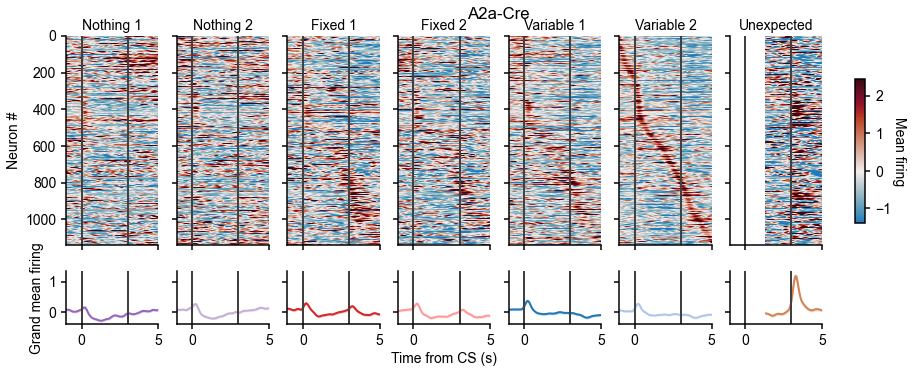

In [25]:
cs_subtimecourse = timecourses[..., ::ds_factor]
cs_subtimecourse_norm = (cs_subtimecourse - np.array(np.nanmean(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)) / np.array(
    np.nanstd(cs_subtimecourse, axis=(0, 2))).reshape(1, -1, 1)
sigma_s = 0.100  # 100 ms
cs_subtimecourse_norm[protocol_info['exclude_tt'], :, std_time < timestamps['stim'] + sigma_s*3] = np.nan

peak_inds = np.argmax(cs_subtimecourse_norm[protocol_info['high_tt'][-1]], axis=1)

for class_label in class_labels:
    val = neuron_info[class_name] == class_label
    suffix = '_' + class_label + '_neurons_sorted_cs' + str(n_trace_types)
    timecourse = cs_subtimecourse_norm[:, val]  #, ::ds_factor]
    sort_sub_peak_inds = np.argsort(peak_inds[val])
    label_heatmap(protocol_info['n_trial_types'], protocol_info['trial_type_names'], pcolor_time,
                  timecourse[pou][:, sort_sub_peak_inds, :], colors['colors'][pou],
                  total_cells, paths, suffix, 'firing')
    plt.suptitle(class_label)

## Fig. 1f-g

<ipython-input-43-149999cea230>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
meta NOT subset; don't know how to subset; dropped


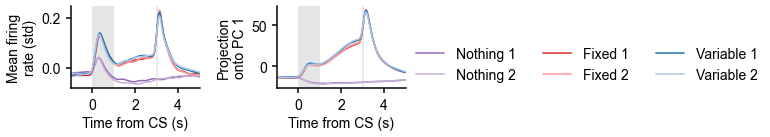

In [43]:
if plot_fig == 'fig1':
    n_comp = 1
    fig, axs = plt.subplots(1, n_comp + 1, squeeze=False, figsize=((n_comp + 1)*3, 1.5),
                            gridspec_kw={'wspace': .6})
    
    concat = np.reshape(np.swapaxes(timecourses[:n_trace_types], 1, 2), 
                        (n_trace_types*len(timestamps['time']), timecourses.shape[1]))
    
    pca = PCA(n_components=n_comp)
    
    for ax in axs.flat:
        setUpLickingTrace(trace_dict, ax=ax, override_ylims=True)
        ax.set_prop_cycle('color', colors['colors'][po])
        ax.set_xlabel('Time from CS (s)')
    
    ax = axs[0, 0]
    ax.set_ylabel('Mean firing\nrate (std)')
    ax.plot(timestamps['time'], np.mean(timecourses[:n_trace_types], axis=1).T)
    
    for i_comp in range(n_comp):
        ax = axs[0, i_comp + 1]
        cs_pca = pca.fit_transform(concat)
        pca_timecourse = np.swapaxes(np.reshape(cs_pca, (n_trace_types, len(timestamps['time']), n_comp)), 1, 2)
        h = ax.plot(timestamps['time'], pca_timecourse[po][:, i_comp, :].T)
        ax.set_ylabel('Projection\nonto PC {}'.format(i_comp + 1))
    
    ax.legend(handles=h, labels=protocol_info['trace_type_names'], loc=(1.04, 0), ncol=3)
    
    fig.tight_layout()
    hide_spines()
    plt.savefig(os.path.join(paths['neural_fig_roots'][0], 'psth_pca_comparison.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(paths['neural_fig_roots'][0], 'psth_pca_comparison.png'), bbox_inches='tight', dpi=300)